In [1]:
import pickle

# data_list = range(493,499)
# for data_number in data_list:
#     with open('../data/both57m_rigged/%d.pkl' % data_number, 'rb') as f:
#         data = pickle.load(f)
    
#     full_annot = data['full_annot']
#     print(data_number, full_annot,"\n")

# (0,5:50) (267,271:70,500) (493,499:38) 
# TODO:(832,836:310)

data_list = range(478)
for data_number in data_list:
    with open('../data/both57m_rigged/%d.pkl' % data_number, 'rb') as f:
        data = pickle.load(f)
    
    data_length = data['length']
    if data_length != 150:
        print(data_number, data_length)

7 210
10 90
13 180
29 89
31 90
34 180
38 60
43 60
48 90
56 120
61 90
64 180
69 90
75 60
82 180
85 210
91 180
97 120
100 120
104 120
108 90
112 90
116 60
119 60
122 180
125 90
128 180
130 90
137 149
140 120
144 180
149 60
152 90
157 60
163 60
170 120
177 89
181 120
183 120
186 196
194 152
198 90
202 60
213 120
217 180
225 60
229 120
236 29
239 180
241 180
243 180
247 210
254 180
262 59
270 90
277 60
287 90
291 90
296 90
301 90
303 180
307 30
311 180
314 120
317 120
324 119
328 180
331 60
334 60
338 120
340 180
352 120
356 120
357 90
361 60
363 60
366 177
374 60
378 210
380 180
382 90
384 180
386 120
390 60
395 60
399 120
404 60
407 180
409 180
411 90
417 120
426 60
437 60
443 90
447 120
450 180
457 120
460 120
465 60


In [2]:
import torch,sys,pickle
import numpy as np
sys.path.append('../utils')
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,get_idxs,np_uv
from smplx import MANO

comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xml_path = '../asset/smplh_rig/scene_smplh_rig.xml'
env = MuJoCoParserClass(name='Common-Rig',rel_xml_path=xml_path,VERBOSE=False)
left_mano_path = '../models/mano_models/MANO_LEFT.pkl'
right_mano_path = '../models/mano_models/MANO_RIGHT.pkl'

left_model = MANO(model_path=left_mano_path,is_rhand=False,use_pca=False,flat_hand_mean=True).to(comp_device)
right_model = MANO(model_path=right_mano_path,is_rhand=True,use_pca=False,flat_hand_mean=True).to(comp_device)

smplh_right_shoulder_pos = env.get_p_joint('r_shoulder1')
smplh_right_wrist_pos = env.get_p_joint('r_wrist1')
smplh_left_shoulder_pos = env.get_p_joint('l_shoulder1')
smplh_arm_length = np.linalg.norm(smplh_right_shoulder_pos-smplh_right_wrist_pos)

# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    for geom_idx in env.get_geom_idxs_from_body_name(body_name=body_name):
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]

In [3]:
data_numbers = range(493,499)
ZERO_ROOT = True

video = []
tick = 0
seq_len = 0

qpos_rig_data = np.empty((0,env.model.nq))
left_joint_pos_array_full = np.empty((0,21,3))
right_joint_pos_array_full = np.empty((0,21,3))

mano2mp = [0,17,18,19,20,1,2,3,4,5,6,7,8,13,14,15,16,9,10,11,12]
MANO_LEFT_UP = np.array([[0, -1, 0],[0, 0, -1],[1, 0, 0]])
MANO_RIGHT_UP = np.array([[0, -1, 0],[0, 0, 1],[-1, 0, 0]])

for data_number in data_numbers:
    with open('../data/both57m_rigged/%d.pkl' % data_number, 'rb') as f:
        data = pickle.load(f)

    qpos_rig_data = np.concatenate((qpos_rig_data, data['qpos']), axis=0)
    seq_len += data['length']

    hand_data_path = '../data/both57m/%d/data.npz'%(data_number)
    hand_data = np.load(hand_data_path)
    hand_seq_len = hand_data['seq_len']

    hand_pose = torch.Tensor(hand_data['hand_pose'].reshape((hand_seq_len,-1))).to(comp_device)
    left_hand_pose = hand_pose[:,:45]
    right_hand_pose = hand_pose[:,45:]

    left_joint_pos_list = []
    right_joint_pos_list = []
    left_extra_joints_idxs = left_model.vertex_joint_selector.extra_joints_idxs
    right_extra_joints_idxs = right_model.vertex_joint_selector.extra_joints_idxs
    finger_idxs = [0,1,2,3,5,6,7,9,10,11,13,14,15,17,18,19]
    fingertip_idxs = [20,4,8,16,12]

    for i in range(hand_seq_len):
        left_output = left_model(hand_pose=left_hand_pose[i].unsqueeze(0),return_verts=True)
        left_finger_pos_output = left_output.joints.detach().cpu().numpy().squeeze()
        left_fingertip_pos_output = left_output.vertices[:,left_extra_joints_idxs,:].detach().cpu().numpy().squeeze()
        left_full_joint_pos = np.zeros((21,3))
        left_full_joint_pos[finger_idxs] = left_finger_pos_output
        left_full_joint_pos[fingertip_idxs] = left_fingertip_pos_output
        left_joint_pos_list.append(left_full_joint_pos)

        right_output = right_model(hand_pose=right_hand_pose[i].unsqueeze(0),return_verts=True)
        right_finger_pos_output = right_output.joints.detach().cpu().numpy().squeeze()
        right_fingertip_pos_output = right_output.vertices[:,right_extra_joints_idxs,:].detach().cpu().numpy().squeeze()
        right_full_joint_pos = np.zeros((21,3))
        right_full_joint_pos[finger_idxs] = right_finger_pos_output
        right_full_joint_pos[fingertip_idxs] = right_fingertip_pos_output
        right_joint_pos_list.append(right_full_joint_pos)

    left_joint_pos_array = np.array(left_joint_pos_list)[:,mano2mp]
    right_joint_pos_array = np.array(right_joint_pos_list)[:,mano2mp]

    for i in range(hand_seq_len):
        left_joint_pos_array[i] = np.matmul(MANO_LEFT_UP,left_joint_pos_array[i].T).T
        right_joint_pos_array[i] = np.matmul(MANO_RIGHT_UP,right_joint_pos_array[i].T).T

    left_joint_pos_array_full = np.concatenate((left_joint_pos_array_full, left_joint_pos_array), axis=0)
    right_joint_pos_array_full = np.concatenate((right_joint_pos_array_full, right_joint_pos_array), axis=0)

In [4]:
start_tick = 38
end_tick = 538
final_len = end_tick - start_tick

ls2le_array = np.zeros((final_len,3))
le2lw_array = np.zeros((final_len,3))
rs2re_array = np.zeros((final_len,3))
re2rw_array = np.zeros((final_len,3))
lw_rot_array = np.zeros((final_len,3,3))
rw_rot_array = np.zeros((final_len,3,3))

left_joint_pos_array_full = left_joint_pos_array_full[start_tick:end_tick]
right_joint_pos_array_full = right_joint_pos_array_full[start_tick:end_tick]

while tick < end_tick-start_tick:
    q_rig = qpos_rig_data[tick+start_tick,:]

    if ZERO_ROOT:
        q_rig[3:7] = 0
    
    env.forward(q=q_rig,INCREASE_TICK=True)
    ls = env.get_p_body('left_shoulder')
    le = env.get_p_body('left_elbow')
    lw = env.get_p_body('left_wrist')
    rs = env.get_p_body('right_shoulder')
    re = env.get_p_body('right_elbow')
    rw = env.get_p_body('right_wrist')

    ls2le_array[tick,:] = np_uv(le-ls)
    le2lw_array[tick,:] = np_uv(lw-le)
    rs2re_array[tick,:] = np_uv(re-rs)
    re2rw_array[tick,:] = np_uv(rw-re)
    lw_rot_array[tick,:] = env.get_R_body('left_wrist')
    rw_rot_array[tick,:] = env.get_R_body('right_wrist')

    tick = tick + 1

In [5]:
SAVE_VIDEO = True
vis_tick = 0

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPLH-Rig',viewer_width=400,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

while vis_tick < final_len:
    q_rig = qpos_rig_data[vis_tick+start_tick,:]
    env.forward(q=q_rig,INCREASE_TICK=True)

    # Plot world frame
    env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
    env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                PLOT_AXIS=False,label="tick:[%d/%d]"%(vis_tick,final_len))
    env.render()  
    frame = env.grab_image()
    video.append(frame)

    for rev_joint_idx,rev_joint_name in zip(env.rev_joint_idxs,env.rev_joint_names):
        axis_joint = env.model.jnt_axis[rev_joint_idx]
        p_joint,R_joint = env.get_pR_joint(joint_name=rev_joint_name)
        axis_world = R_joint@axis_joint
        axis_rgba = np.append(np.eye(3)[:,np.argmax(axis_joint)],0.2)
        axis_len,axis_r = 0.02,0.002
        env.plot_arrow_fr2to(
            p_fr=p_joint,p_to=p_joint+axis_len*axis_world,
            r=axis_r,rgba=axis_rgba)

    vis_tick = vis_tick + 1
    if vis_tick == final_len:
        if not SAVE_VIDEO: vis_tick = 0

env.close_viewer()

if SAVE_VIDEO:
    import mediapy as media
    media.show_video(images=video,fps=15,width=400)

In [6]:
recon_tick = 0

# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPLH-Rig',viewer_width=400,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

BODY_NAMES = ['left_elbow','left_wrist','right_elbow','right_wrist']
JOINT_NAMES = ['l_shoulder1', 'l_shoulder2', 'l_shoulder3', 'l_elbow', 'l_wrist1', 'l_wrist2', 'l_wrist3',
               'r_shoulder1', 'r_shoulder2', 'r_shoulder3', 'r_elbow', 'r_wrist1', 'r_wrist2', 'r_wrist3']

hand_indices = list(range(27,49)) + list(range(54,76))
video = []
wrist_dist_list = []

ls = env.get_p_body('left_shoulder')
le = env.get_p_body('left_elbow')
lw = env.get_p_body('left_wrist')
rs = env.get_p_body('right_shoulder')
re = env.get_p_body('right_elbow')
rw = env.get_p_body('right_wrist')

len_ls2le = np.linalg.norm(le-ls)
len_le2lw = np.linalg.norm(lw-le)
len_rs2re = np.linalg.norm(re-rs)
len_re2rw = np.linalg.norm(rw-re)
lw_array = np.zeros((final_len,3))
rw_array = np.zeros((final_len,3))

while recon_tick < final_len:
    p_target = {}
    p_target['left_elbow'] = ls + len_ls2le * ls2le_array[recon_tick,:]
    p_target['left_wrist'] = p_target['left_elbow'] + len_le2lw * le2lw_array[recon_tick,:]
    p_target['right_elbow'] = rs + len_rs2re * rs2re_array[recon_tick,]
    p_target['right_wrist'] = p_target['right_elbow'] + len_re2rw * re2rw_array[recon_tick,:]

    lw_array[recon_tick,:] = p_target['left_wrist']
    rw_array[recon_tick,:] = p_target['right_wrist']
    
    idxs = get_idxs(env.rev_joint_names,JOINT_NAMES)
    q_mins_body,q_maxs_body = env.rev_joint_mins[idxs],env.rev_joint_maxs[idxs]
    joint_idxs_fwd_body = env.get_idxs_fwd(joint_names=JOINT_NAMES)
    joint_idxs_jac_body = env.get_idxs_jac(joint_names=JOINT_NAMES)

    q_body = env.get_qpos_joints(JOINT_NAMES)
    body_diff = 1e3
    prev_q_pos = env.data.qpos.copy()

    while body_diff > 1e-4:
        for ik_tick in range(1):
            J_list,ik_err_list = [],[]
            for ik_body_name in BODY_NAMES:
                ik_p_trgt = p_target[ik_body_name]
                ik_R_trgt = None
                IK_P = True
                IK_R = False
                J,ik_err = env.get_ik_ingredients(
                    body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                    IK_P=IK_P,IK_R=IK_R)
                J_list.append(J)
                ik_err_list.append(ik_err)
            J_stack      = np.vstack(J_list)
            ik_err_stack = np.hstack(ik_err_list)
            dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
            q_body = q_body + dq[joint_idxs_jac_body]

            q_body = np.clip(q_body,q_mins_body,q_maxs_body)
            env.forward(q=q_body,joint_idxs=joint_idxs_fwd_body)

            q_env = env.data.qpos.copy()
            body_diff = np.linalg.norm(q_env - prev_q_pos)
            prev_q_pos=q_env.copy()

    q_rig = qpos_rig_data[recon_tick+start_tick,:]
    q_env[hand_indices] = q_rig[hand_indices]
    env.forward(q=q_env,INCREASE_TICK=True)

    left_wrist_pos = env.get_p_body('left_wrist')
    right_wrist_pos = env.get_p_body('right_wrist')
    wrist_dist = np.linalg.norm(left_wrist_pos - right_wrist_pos)
    wrist_dist_list.append(wrist_dist)
    wrist_pos = np.vstack((left_wrist_pos,right_wrist_pos))

    env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(recon_tick,final_len),axis_len=0.5,axis_width=0.005)
    env.plot_traj(wrist_pos,rgba=[0,0,1,1],plot_line=True,plot_sphere=True,sphere_r=0.005)
    env.render()

    video.append(env.grab_image())
    recon_tick += 1

env.close_viewer()
media.show_video(images=video,fps=15,width=400)

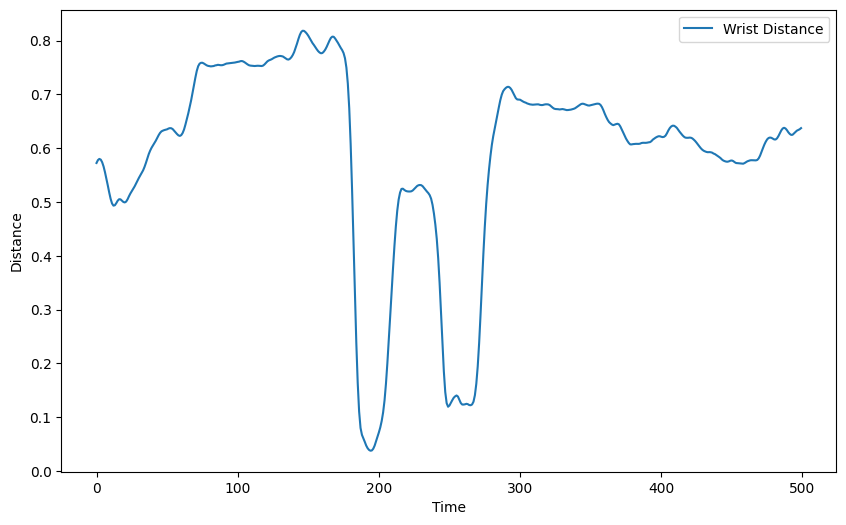

In [7]:
wrist_dist_array = np.array(wrist_dist_list)

import matplotlib.pyplot as plt

time = np.arange(0,wrist_dist_array.shape[0])
plt.figure(figsize=(10,6))
plt.plot(time, wrist_dist_array,label='Wrist Distance')

plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()

plt.show()

In [8]:
sys.path.append('../ability_hand')
from pathlib import Path

from dex_retargeting.constants import RobotName, RetargetingType, HandType, get_default_config_path
from dex_retargeting.retargeting_config import RetargetingConfig

robot_name = RobotName.ability
retargeting_type = RetargetingType.dexpilot
robot_dir = Path().absolute().parent / "ability_hand" / "assets" 
RetargetingConfig.set_default_urdf_dir(str(robot_dir))

hand_type_left = HandType.left
config_path = get_default_config_path(robot_name, retargeting_type, hand_type_left)
left_retargeting = RetargetingConfig.load_from_file(config_path).build()

left_ability_joints_list = []
right_ability_joints_list = []

for i in range(final_len):
    retargeting_type = left_retargeting.optimizer.retargeting_type
    indices = left_retargeting.optimizer.target_link_human_indices
    origin_indices = indices[0, :]
    task_indices = indices[1, :]
    
    left_joint_pos = left_joint_pos_array_full[i]
    ref_value = left_joint_pos[task_indices, :] - left_joint_pos[origin_indices, :]
    left_qpos = left_retargeting.retarget(ref_value)
    left_ability_joints_list.append(left_qpos)

left_joint_names=left_retargeting.optimizer.robot.dof_joint_names
left_ability_joints_array = np.array(left_ability_joints_list)

hand_type_right = HandType.right
config_path = get_default_config_path(robot_name, retargeting_type, hand_type_right)
right_retargeting = RetargetingConfig.load_from_file(config_path).build()

for i in range(final_len):
    retargeting_type = right_retargeting.optimizer.retargeting_type
    indices = right_retargeting.optimizer.target_link_human_indices
    origin_indices = indices[0, :]
    task_indices = indices[1, :]

    right_joint_pos = right_joint_pos_array_full[i]
    ref_value = right_joint_pos[task_indices, :] - right_joint_pos[origin_indices, :]
    right_qpos = right_retargeting.retarget(ref_value)
    right_ability_joints_list.append(right_qpos)

right_joint_names=right_retargeting.optimizer.robot.dof_joint_names
right_ability_joints_array = np.array(right_ability_joints_list)

 Mimic joint adaptor enabled. The mimic joint tags in the URDF will be considered during retargeting.
To disable mimic joint adaptor, consider setting ignore_mimic_joint=True in the configuration. 
 Mimic joint adaptor enabled. The mimic joint tags in the URDF will be considered during retargeting.
To disable mimic joint adaptor, consider setting ignore_mimic_joint=True in the configuration. 


In [9]:
xml_path = '../asset/kimlab_dualarms/scene_dualarms.xml'
env = MuJoCoParserClass(name='Dual Arms',rel_xml_path=xml_path,VERBOSE=False)
env.set_geom_color(
    rgba                = (0.2,0.2,0.2,0.9),
    body_names_to_color = [
        'robot1/end_link','robot1/index_L1','robot1/index_L2','robot1/index_tip',
        'robot1/middle_L1','robot1/middle_L2','robot1/middle_tip',
        'robot1/ring_L1','robot1/ring_L2','robot1/ring_tip',
        'robot1/pinky_L1','robot1/pinky_L2','robot1/pinky_tip',
        'robot1/thumb_L1','robot1/thumb_L2','robot1/thumb_tip',
        'robot2/end_link','robot2/index_L1','robot2/index_L2','robot2/index_tip',
        'robot2/middle_L1','robot2/middle_L2','robot2/middle_tip',
        'robot2/ring_L1','robot2/ring_L2','robot2/ring_tip',
        'robot2/pinky_L1','robot2/pinky_L2','robot2/pinky_tip',
        'robot2/thumb_L1','robot2/thumb_L2','robot2/thumb_tip'],
)

q_init = env.data.qpos.copy()
q_init[18] = -np.pi/2
env.forward(q=q_init)

robot_right_shoulder_pos = env.get_p_joint('robot2/joint1')
robot_right_wrist_pos = env.get_p_joint('robot2/joint6')
robot_left_shoulder_pos = env.get_p_joint('robot1/joint1')

robot_arm_length = np.linalg.norm(robot_right_shoulder_pos-robot_right_wrist_pos)
print ("Done.")

Done.


In [10]:
from tqdm import tqdm

env.init_viewer(viewer_title='Dual Arms',viewer_width=400,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

BODY_NAMES = ['robot1/end_link','robot2/end_link']
JOINT_NAMES = ['robot1/joint1','robot1/joint2','robot1/joint3','robot1/joint4','robot1/joint5','robot1/joint6',
               'robot2/joint1','robot2/joint2','robot2/joint3','robot2/joint4','robot2/joint5','robot2/joint6']

q_env_array = np.zeros((final_len,env.model.nq))
p_target_list = []
R_target_list = []

for tick in tqdm(range(final_len), desc="Processing"):
    p_target = {}
    delta_lw = (lw_array[tick,:]-smplh_left_shoulder_pos)*robot_arm_length/smplh_arm_length
    delta_lw[0] /= 2
    delta_lw[0] += 0.25
    if delta_lw[1] > 0: delta_lw[1] /= 3
    delta_lw[2] /= 2
    p_target['robot1/end_link'] = delta_lw + robot_left_shoulder_pos
    delta_rw = (rw_array[tick,:]-smplh_right_shoulder_pos)*robot_arm_length/smplh_arm_length
    delta_rw[0] /= 2
    delta_rw[0] += 0.25
    if delta_rw[1] < 0: delta_rw[1] /= 3
    delta_rw[2] /= 2
    p_target['robot2/end_link'] = delta_rw + robot_right_shoulder_pos
    R_target = {}
    R_target['robot1/end_link'] = lw_rot_array[tick,:] @ rpy2r(np.radians([0,0,90]))
    R_target['robot2/end_link'] = rw_rot_array[tick,:] @ rpy2r(np.radians([0,0,-90]))
    p_target_list.append(p_target)
    R_target_list.append(R_target)

    idxs = get_idxs(env.rev_joint_names,JOINT_NAMES)
    q_mins_body,q_maxs_body = env.rev_joint_mins[idxs],env.rev_joint_maxs[idxs]
    joint_idxs_fwd_body = env.get_idxs_fwd(joint_names=JOINT_NAMES)
    joint_idxs_jac_body = env.get_idxs_jac(joint_names=JOINT_NAMES)

    q_body = env.get_qpos_joints(JOINT_NAMES)
    body_diff = 1e3
    prev_q_pos = env.data.qpos.copy()

    while body_diff > 1e-4:
        for ik_tick in range(1):
            J_list,ik_err_list = [],[]
            for ik_body_name in BODY_NAMES:
                ik_p_trgt = p_target[ik_body_name]
                ik_R_trgt = R_target[ik_body_name]
                IK_P = True
                IK_R = True
                J,ik_err = env.get_ik_ingredients(
                    body_name=ik_body_name,p_trgt=ik_p_trgt,R_trgt=ik_R_trgt,
                    IK_P=IK_P,IK_R=IK_R)
                J_list.append(J)
                ik_err_list.append(ik_err)
            J_stack      = np.vstack(J_list)
            ik_err_stack = np.hstack(ik_err_list)
            dq = env.damped_ls(J_stack,ik_err_stack,stepsize=1,eps=1e-2,th=np.radians(1.0))
            q_body = q_body + dq[joint_idxs_jac_body]

            q_body = np.clip(q_body,q_mins_body,q_maxs_body)
            env.forward(q=q_body,joint_idxs=joint_idxs_fwd_body)

            q_env = env.data.qpos.copy()
            body_diff = np.linalg.norm(q_env - prev_q_pos)
            prev_q_pos=q_env.copy()

    q_env_array[tick,:] = q_env
    # env.render()

env.close_viewer()

Processing: 100%|██████████| 500/500 [00:08<00:00, 59.68it/s] 


In [13]:
import mediapy

env.init_viewer(viewer_title='Dual-Arm',viewer_width=400,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

SAVE_VIDEO = True

video = []
robot_wrist_dist_list = []
plot_tick = 0

left_hand_joint_names = ['robot1/' + i for i in left_joint_names]
left_hand_idxs = get_idxs(env.joint_names,left_hand_joint_names)
right_hand_joint_names = ['robot2/' + i for i in right_joint_names]
right_hand_idxs = get_idxs(env.joint_names,right_hand_joint_names)
hand_idxs = np.concatenate((left_hand_idxs,right_hand_idxs))

q_robot_array = np.zeros((final_len,env.model.nq))

while plot_tick < final_len and env.is_viewer_alive():
    q_robot = q_env_array[plot_tick,:]
    left_ability_joints = left_ability_joints_array[plot_tick]
    right_ability_joints = right_ability_joints_array[plot_tick]
    ability_joints = np.concatenate((left_ability_joints,right_ability_joints))
    q_robot[hand_idxs] = ability_joints
    env.forward(q=q_robot,INCREASE_TICK=True)

    robot_left_wrist_pos = env.get_p_body('robot1/end_link')
    robot_right_wrist_pos = env.get_p_body('robot2/end_link')
    robot_wrist_dist = np.linalg.norm(robot_left_wrist_pos - robot_right_wrist_pos)
    robot_wrist_dist_list.append(robot_wrist_dist)
    robot_wrist_pos = np.vstack((robot_left_wrist_pos,robot_right_wrist_pos))

    env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(plot_tick,final_len),axis_len=0.5,axis_width=0.005)
    env.plot_traj(robot_wrist_pos,rgba=[1,0,0,1],plot_line=True,plot_sphere=True,sphere_r=0.005)
    env.render()

    p_target = p_target_list[plot_tick]
    R_target = R_target_list[plot_tick]
    env.plot_T(p=p_target['robot1/end_link'],R=R_target['robot1/end_link'],PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)
    env.plot_T(p=p_target['robot2/end_link'],R=R_target['robot2/end_link'],PLOT_AXIS=True,axis_len=0.1,axis_width=0.005)

    q_robot_array[plot_tick,:] = env.data.qpos.copy()
    video.append(env.grab_image())
    plot_tick += 1
    if plot_tick == final_len:
        if not SAVE_VIDEO: plot_tick = 0

env.close_viewer()
if SAVE_VIDEO:mediapy.show_video(images=video,fps=15,width=400)

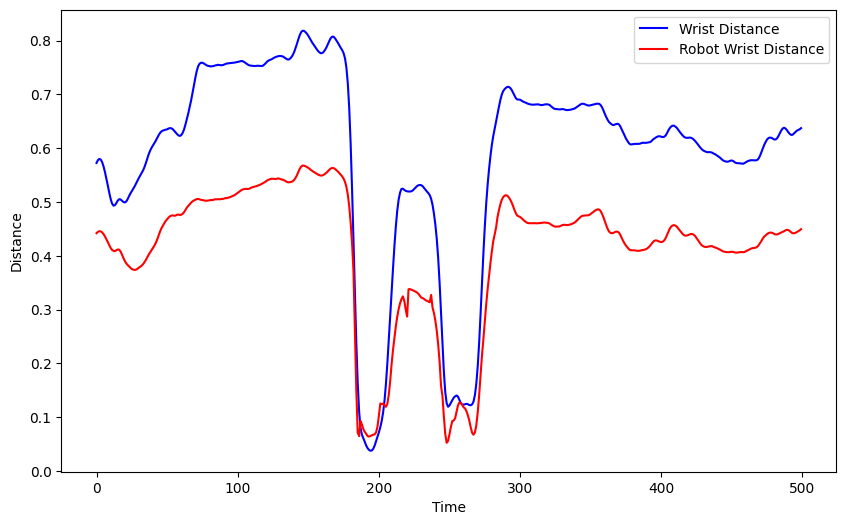

In [14]:
robot_wrist_dist_array = np.array(robot_wrist_dist_list)

import matplotlib.pyplot as plt

time = np.arange(0, robot_wrist_dist_array.shape[0])
plt.figure(figsize=(10, 6))
plt.plot(time, wrist_dist_array, 'b-', label='Wrist Distance')
plt.plot(time, robot_wrist_dist_array, 'r-', label='Robot Wrist Distance')

plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()

plt.show()

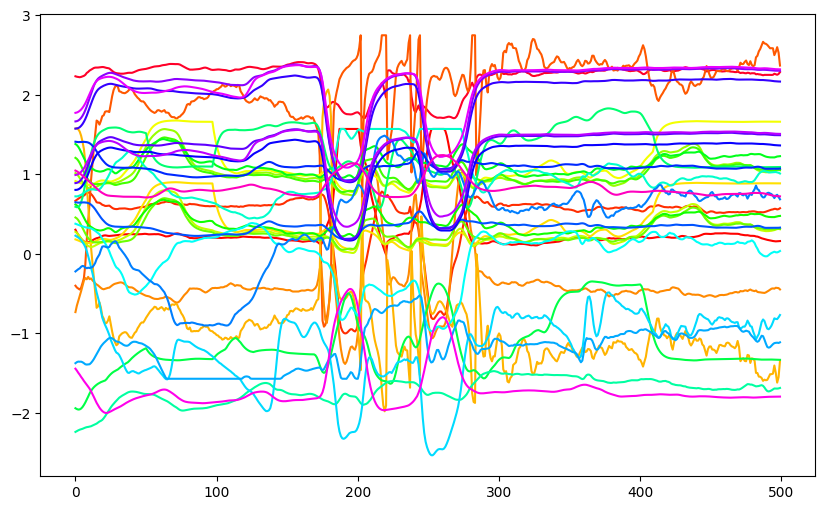

In [15]:
import matplotlib.pyplot as plt

time = np.arange(0,q_robot_array.shape[0])
plt.figure(figsize=(10,6))
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,q_robot_array.shape[1])]
for i in range(q_robot_array.shape[1]):
    plt.plot(time, q_robot_array[:,i], color=cs[i])

In [16]:
import mujoco,time
sys.path.append('../utils')
from mujoco_parser import init_ik_info,add_ik_info,get_dq_from_ik_info
from utility import smooth_optm_1d

joint_names_for_ik = env.rev_joint_names
collision_push_len = 0.0005
gap_per_step_cm = 0.0005
max_gap_cm = 2.0
acc_limit = 300
max_ik_tick = 100
body_name_to_exlude = "world"
hand_names = [
    'robot1/index_L1', 'robot1/index_L2', 'robot1/index_tip', 
    'robot1/middle_L1', 'robot1/middle_L2', 'robot1/middle_tip',
    'robot1/ring_L1', 'robot1/ring_L2', 'robot1/ring_tip',
    'robot1/pinky_L1', 'robot1/pinky_L2', 'robot1/pinky_tip',
    'robot1/thumb_L1', 'robot1/thumb_L2', 'robot1/thumb_tip',
    'robot2/index_L1', 'robot2/index_L2', 'robot2/index_tip',
    'robot2/middle_L1', 'robot2/middle_L2', 'robot2/middle_tip',
    'robot2/ring_L1', 'robot2/ring_L2', 'robot2/ring_tip',
    'robot2/pinky_L1', 'robot2/pinky_L2', 'robot2/pinky_tip',
    'robot2/thumb_L1', 'robot2/thumb_L2', 'robot2/thumb_tip'
    ]

L = final_len
qpos_array = q_robot_array.copy()
qpos_init_array = qpos_array.copy()

ch_step = 0
while True:
    collision_gap_cm = ch_step * gap_per_step_cm
    if collision_gap_cm > max_gap_cm:
        collision_gap_cm = max_gap_cm
    env.model.geom_gap = collision_gap_cm / 100
    env.model.geom_margin = collision_gap_cm / 100

    qpos_cf_list = []
    n_sc = 0
    time_bc = time.time()

    for tick in range(L):
        env.forward(q=qpos_array[tick,:])
        sc_occured = False

        for ik_tick in range(max_ik_tick):
            p_contact_list,f_contact_list = [],[]
            contact_body1_list, contact_body2_list = [],[]
            
            for c_idx in range(env.data.ncon):
                contact = env.data.contact[c_idx]
                p_contact = contact.pos
                R_frame = contact.frame.reshape((3,3))

                f_contact_local = np.zeros(6,dtype=np.float64)
                mujoco.mj_contactForce(env.model,env.data,0,f_contact_local)
                f_contact = R_frame @ f_contact_local[:3]
                f_contact = np_uv(f_contact)

                contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
                contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

                if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
                    continue

                if (contact_body1 in hand_names) and (contact_body2 in hand_names):
                    continue

                p_contact_list.append(p_contact)
                f_contact_list.append(f_contact)
                contact_body1_list.append(contact_body1)
                contact_body2_list.append(contact_body2)

            ik_info_collision = init_ik_info()
            n_contact = len(p_contact_list)

            if n_contact > 0:
                sc_occured = True
                for c_idx in range(n_contact):
                    f_contact = f_contact_list[c_idx]
                    contact_body1 = contact_body1_list[c_idx]
                    contact_body2 = contact_body2_list[c_idx]
                    p_body1 = env.get_p_body(body_name=contact_body1)
                    p_body2 = env.get_p_body(body_name=contact_body2)

                    add_ik_info(
                        ik_info = ik_info_collision,
                        body_name = contact_body1,
                        p_trgt = p_body1 - collision_push_len * np_uv(f_contact)   
                    )
                    add_ik_info(
                        ik_info = ik_info_collision,
                        body_name = contact_body2,
                        p_trgt = p_body2 + collision_push_len * np_uv(f_contact)
                    )
                
                joint_idxs_jac_collision = env.get_idxs_jac(joint_names=joint_names_for_ik)
                dq,ik_err_stack = get_dq_from_ik_info(
                    env=env,
                    ik_info=ik_info_collision,
                    stepsize=1,
                    eps=1e-2,
                    th=np.radians(3.0),
                    joint_idxs_jac=joint_idxs_jac_collision,
                )

                qpos = env.data.qpos.copy()
                mujoco.mj_integratePos(env.model,qpos,dq,1)
                qpos = np.clip(qpos,env.model.jnt_range[:,0],env.model.jnt_range[:,1])
                env.forward(q=qpos)

            else:
                break
        
        if sc_occured: n_sc = n_sc + 1
        qpos_cf_list.append(env.data.qpos.copy())

    time_ac = time.time()
    print ("[%d] [step-1:collision handling] n_sc:[%d] collision_gap:[%.2f]cm time taken:[%f]s"%(ch_step,n_sc,collision_gap_cm,time_ac-time_bc))

    time_bs = time.time()
    qpos_cf_array = np.array(qpos_cf_list)
    qpos_cf_smt_array = qpos_cf_array.copy()

    for d_idx in env.get_idxs_fwd(joint_names=joint_names_for_ik):
        qpos_cf_smt_array[:,d_idx] = smooth_optm_1d(
            traj      = qpos_cf_array[:,d_idx],
            dt        = env.dt,
            acc_limit = acc_limit,
        )

    env.model.geom_gap = 0
    env.model_geom_margin = 0
    n_sc = 0

    for tick in range(L):
        q_cf_smt = qpos_cf_smt_array[tick,:]
        env.forward(q=q_cf_smt)
        sc_occured = False

        p_contact_list,f_contact_list = [],[]
        contact_body1_list,contact_body2_list = [],[]

        for c_idx in range(env.data.ncon):
            contact = env.data.contact[c_idx]
            contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
            contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

            if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
                continue
            if (contact_body1 in hand_names) and (contact_body2 in hand_names):
                continue
            sc_occured = True

        if sc_occured: n_sc = n_sc + 1

    qpos_array = qpos_cf_smt_array.copy()
    for i in range(qpos_array.shape[0]):
        qpos = qpos_array[i,:]
        qpos = np.clip(qpos,env.model.jnt_range[:,0],env.model.jnt_range[:,1])
        qpos_array[i,:] = qpos

    time_as = time.time()
    print ("[%d] [step-2:smoothing] n_sc:[%d] time taken:[%f]s"%(ch_step,n_sc,time_as-time_bs))

    if n_sc == 0: break

    ch_step = ch_step + 1

q_robot_array_cf_smoothed = qpos_array

[0] [step-1:collision handling] n_sc:[46] collision_gap:[0.00]cm time taken:[4.551841]s
[0] [step-2:smoothing] n_sc:[16] time taken:[0.782423]s
[1] [step-1:collision handling] n_sc:[16] collision_gap:[0.00]cm time taken:[0.393993]s
[1] [step-2:smoothing] n_sc:[12] time taken:[0.732777]s
[2] [step-1:collision handling] n_sc:[12] collision_gap:[0.00]cm time taken:[0.137003]s
[2] [step-2:smoothing] n_sc:[9] time taken:[0.718982]s
[3] [step-1:collision handling] n_sc:[9] collision_gap:[0.00]cm time taken:[0.083204]s
[3] [step-2:smoothing] n_sc:[8] time taken:[0.717052]s
[4] [step-1:collision handling] n_sc:[8] collision_gap:[0.00]cm time taken:[0.071617]s
[4] [step-2:smoothing] n_sc:[6] time taken:[0.730324]s
[5] [step-1:collision handling] n_sc:[6] collision_gap:[0.00]cm time taken:[0.076964]s
[5] [step-2:smoothing] n_sc:[4] time taken:[0.721793]s
[6] [step-1:collision handling] n_sc:[4] collision_gap:[0.00]cm time taken:[0.067049]s
[6] [step-2:smoothing] n_sc:[2] time taken:[0.722522]s
[

In [17]:
# import mujoco,time
# sys.path.append('../utils')
# from mujoco_parser import init_ik_info,add_ik_info,get_dq_from_ik_info
# from utility import smooth_optm_1d

# joint_names_for_ik = env.rev_joint_names
# collision_push_len = 0.001
# gap_per_step_cm = 0.001
# max_gap_cm = 2.0
# acc_limit = 700
# max_ik_tick = 100
# body_name_to_exlude = "world"
# hand_names = [
#     'robot1/index_L1', 'robot1/index_L2', 'robot1/index_tip', 
#     'robot1/middle_L1', 'robot1/middle_L2', 'robot1/middle_tip',
#     'robot1/ring_L1', 'robot1/ring_L2', 'robot1/ring_tip',
#     'robot1/pinky_L1', 'robot1/pinky_L2', 'robot1/pinky_tip',
#     'robot1/thumb_L1', 'robot1/thumb_L2', 'robot1/thumb_tip',
#     'robot2/index_L1', 'robot2/index_L2', 'robot2/index_tip',
#     'robot2/middle_L1', 'robot2/middle_L2', 'robot2/middle_tip',
#     'robot2/ring_L1', 'robot2/ring_L2', 'robot2/ring_tip',
#     'robot2/pinky_L1', 'robot2/pinky_L2', 'robot2/pinky_tip',
#     'robot2/thumb_L1', 'robot2/thumb_L2', 'robot2/thumb_tip'
#     ]

# L = final_len

# ch_step = 0
# while True:
#     collision_gap_cm = ch_step * gap_per_step_cm
#     if collision_gap_cm > max_gap_cm:
#         collision_gap_cm = max_gap_cm
#     env.model.geom_gap = collision_gap_cm / 100
#     env.model.geom_margin = collision_gap_cm / 100

#     qpos_cf_list = []
#     n_sc = 0
#     time_bc = time.time()

#     for tick in range(L):
#         env.forward(q=q_robot_array_cf_smoothed[tick,:])
#         sc_occured = False

#         for ik_tick in range(max_ik_tick):
#             p_contact_list,f_contact_list = [],[]
#             contact_body1_list, contact_body2_list = [],[]
            
#             for c_idx in range(env.data.ncon):
#                 contact = env.data.contact[c_idx]
#                 p_contact = contact.pos
#                 R_frame = contact.frame.reshape((3,3))

#                 f_contact_local = np.zeros(6,dtype=np.float64)
#                 mujoco.mj_contactForce(env.model,env.data,0,f_contact_local)
#                 f_contact = R_frame @ f_contact_local[:3]
#                 f_contact = np_uv(f_contact)

#                 contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
#                 contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

#                 if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
#                     continue

#                 p_contact_list.append(p_contact)
#                 f_contact_list.append(f_contact)
#                 contact_body1_list.append(contact_body1)
#                 contact_body2_list.append(contact_body2)

#             ik_info_collision = init_ik_info()
#             n_contact = len(p_contact_list)

#             if n_contact > 0:
#                 sc_occured = True
#                 for c_idx in range(n_contact):
#                     f_contact = f_contact_list[c_idx]
#                     contact_body1 = contact_body1_list[c_idx]
#                     contact_body2 = contact_body2_list[c_idx]
#                     p_body1 = env.get_p_body(body_name=contact_body1)
#                     p_body2 = env.get_p_body(body_name=contact_body2)

#                     if contact_body1 in ['robot1/thumb_L2','robot2/thumb_L2']:
#                         p_trgt1 = p_body1 - collision_push_len * np_uv(f_contact)
#                     else: p_trgt1 = p_body1  

#                     if contact_body2 in ['robot1/thumb_L2','robot2/thumb_L2']:
#                         p_trgt2 = p_body2 + collision_push_len * np_uv(f_contact)
#                     else: p_trgt2 = p_body2

#                     add_ik_info(
#                         ik_info = ik_info_collision,
#                         body_name = contact_body1,
#                         p_trgt = p_trgt1   
#                     )
#                     add_ik_info(
#                         ik_info = ik_info_collision,
#                         body_name = contact_body2,
#                         p_trgt = p_trgt2
#                     )
                
#                 joint_idxs_jac_collision = env.get_idxs_jac(joint_names=joint_names_for_ik)
#                 dq,ik_err_stack = get_dq_from_ik_info(
#                     env=env,
#                     ik_info=ik_info_collision,
#                     stepsize=1,
#                     eps=1e-2,
#                     th=np.radians(3.0),
#                     joint_idxs_jac=joint_idxs_jac_collision,
#                 )

#                 qpos = env.data.qpos.copy()
#                 mujoco.mj_integratePos(env.model,qpos,dq,1)
#                 qpos = np.clip(qpos,env.model.jnt_range[:,0],env.model.jnt_range[:,1])
#                 env.forward(q=qpos)

#             else:
#                 break
        
#         if sc_occured: n_sc = n_sc + 1
#         qpos_cf_list.append(env.data.qpos.copy())

#     time_ac = time.time()
#     print ("[%d] [step-1:collision handling] n_sc:[%d] collision_gap:[%.2f]cm time taken:[%f]s"%(ch_step,n_sc,collision_gap_cm,time_ac-time_bc))

#     time_bs = time.time()
#     qpos_cf_array = np.array(qpos_cf_list)
#     qpos_cf_smt_array = qpos_cf_array.copy()

#     for d_idx in env.get_idxs_fwd(joint_names=joint_names_for_ik):
#         qpos_cf_smt_array[:,d_idx] = smooth_optm_1d(
#             traj      = qpos_cf_array[:,d_idx],
#             dt        = env.dt,
#             acc_limit = acc_limit,
#         )

#     env.model.geom_gap = 0
#     env.model_geom_margin = 0
#     n_sc = 0

#     for tick in range(L):
#         q_cf_smt = qpos_cf_smt_array[tick,:]
#         env.forward(q=q_cf_smt)
#         sc_occured = False

#         p_contact_list,f_contact_list = [],[]
#         contact_body1_list,contact_body2_list = [],[]

#         for c_idx in range(env.data.ncon):
#             contact = env.data.contact[c_idx]
#             contact_body1 = env.body_names[env.model.geom_bodyid[contact.geom1]]
#             contact_body2 = env.body_names[env.model.geom_bodyid[contact.geom2]]

#             if (contact_body1==body_name_to_exlude) or (contact_body2==body_name_to_exlude):
#                 continue

#             sc_occured = True

#         if sc_occured: n_sc = n_sc + 1

#     qpos_array = qpos_cf_smt_array.copy()
#     for i in range(qpos_array.shape[0]):
#         qpos = qpos_array[i,:]
#         qpos = np.clip(qpos,env.model.jnt_range[:,0],env.model.jnt_range[:,1])
#         qpos_array[i,:] = qpos

#     time_as = time.time()
#     print ("[%d] [step-2:smoothing] n_sc:[%d] time taken:[%f]s"%(ch_step,n_sc,time_as-time_bs))

#     if n_sc == 0: break

#     ch_step = ch_step + 1

# q_robot_array_hand_cf_smoothed = qpos_array

In [18]:
import mediapy

env.init_viewer(viewer_title='Dual-Arm',viewer_width=800,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=180,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

SAVE_VIDEO = True

video = []
robot_wrist_dist_smoothed_list = []
plot_tick = 0
q_robot_export = np.zeros((final_len,env.model.nq))

while plot_tick < final_len and env.is_viewer_alive():
    q_robot = q_robot_array_cf_smoothed[plot_tick,:]
    env.forward(q=q_robot,INCREASE_TICK=True)
    robot_left_wrist_pos = env.get_p_body('robot1/end_link')
    robot_right_wrist_pos = env.get_p_body('robot2/end_link')
    robot_wrist_dist = np.linalg.norm(robot_left_wrist_pos - robot_right_wrist_pos)
    robot_wrist_dist_smoothed_list.append(robot_wrist_dist)
    robot_wrist_pos = np.vstack((robot_left_wrist_pos,robot_right_wrist_pos))

    env.plot_T(p=np.zeros(3),R=np.eye(3),label="Tick: [%d/%d]"%(plot_tick,final_len),axis_len=0.5,axis_width=0.005)
    env.plot_traj(robot_wrist_pos,rgba=[0,1,0,1],plot_line=True,plot_sphere=True,sphere_r=0.005)
    env.plot_contact_info(h_arrow=0.1,rgba_arrow=[1,0,0,1],PRINT_CONTACT_BODY=True) # contact
    env.render()
    
    q_robot_export[plot_tick,:] = q_robot
    video.append(env.grab_image())
    plot_tick += 1
    if plot_tick == final_len:
        if not SAVE_VIDEO: plot_tick = 0

env.close_viewer()
if SAVE_VIDEO:mediapy.show_video(images=video,fps=15,width=800)

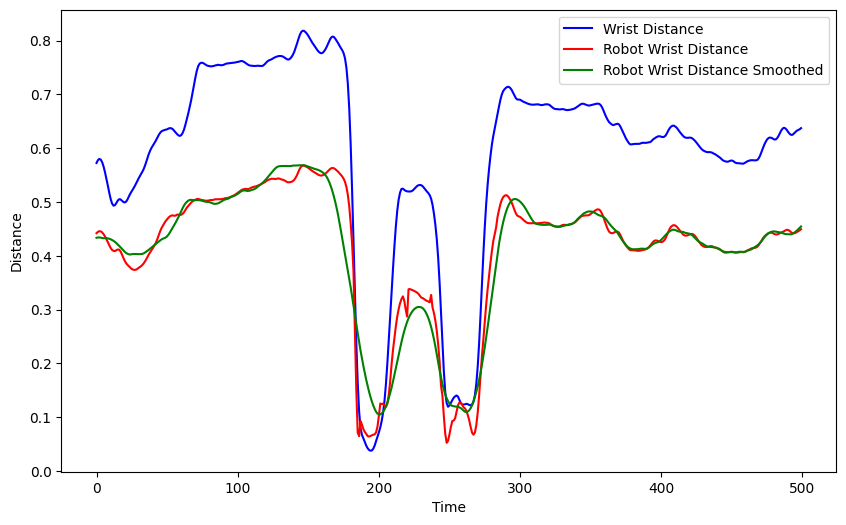

In [19]:
robot_wrist_dist_smoothed_array = np.array(robot_wrist_dist_smoothed_list)

import matplotlib.pyplot as plt

time = np.arange(0, robot_wrist_dist_smoothed_array.shape[0])
plt.figure(figsize=(10, 6))
plt.plot(time, wrist_dist_array, 'b-', label='Wrist Distance')
plt.plot(time, robot_wrist_dist_array, 'r-', label='Robot Wrist Distance')
plt.plot(time, robot_wrist_dist_smoothed_array, 'g-', label='Robot Wrist Distance Smoothed')

plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()

plt.show()

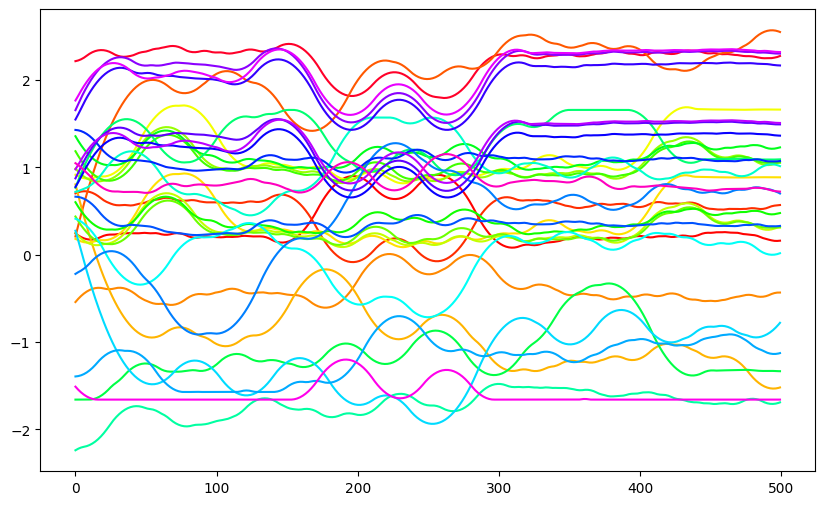

In [20]:
import matplotlib.pyplot as plt

time = np.arange(0,q_robot_export.shape[0])
plt.figure(figsize=(10,6))
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,q_robot_export.shape[1])]
for i in range(q_robot_array_cf_smoothed.shape[1]):
    plt.plot(time, q_robot_export[:,i], color=cs[i])

In [21]:
# header_name = 'robot1/joint1,robot1/joint2,robot1/joint3,robot1/joint4,robot1/joint5,robot1/joint6,\
#                robot1/index_q1,robot1/index_q2,robot1/middle_q1,robot1/middle_q2,robot1/ring_q1,robot1/ring_q2,robot1/pinky_q1,robot1/pinky_q2,robot1/thumb_q1,robot1/thumb_q2,\
#                robot2/joint1,robot2/joint2,robot2/joint3,robot2/joint4,robot2/joint5,robot2/joint6,\
#                robot2/index_q1,robot2/index_q2,robot2/middle_q1,robot2/middle_q2,robot2/ring_q1,robot2/ring_q2,robot2/pinky_q1,robot2/pinky_q2,robot2/thumb_q1,robot2/thumb_q2'

# np.savetxt(
#     fname="dualarms_test_" + str(data_numbers[0]) + "_" + str(data_numbers[-1]) + ".csv",
#     # fname="dualarms_test.csv",
#     X=q_robot_export[:final_len,:],
#     delimiter=',',
#     # header=header_name,
#     fmt='%.6f'
#     )